## Causality Analysis of Open Covid-19 Epidemiology Data in Madrid
By: Ke Li
Date: March28, 2021

### Process CSV Raw Data

In [6]:
%load_ext autoreload
%autoreload 2

project_root      = r"/home/coco/code/dlr/explore_tigramite"

path_to_data_src  = os.path.join(project_root, "src","data")
path_to_model_src = os.path.join(project_root, "src","model")

path_to_processed_data = os.path.join(project_root,"data","processed")
path_to_raw_data       = os.path.join(project_root,"data","raw")

sys.path.insert(0, path_to_data_src)
sys.path.insert(0, path_to_model_src)
sys.path.insert(0, path_to_processed_data)
sys.path.insert(0, path_to_raw_data)

import pandas as pd
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
epi = pd.read_csv("https://storage.googleapis.com/covid19-open-data/v2/epidemiology.csv")

In [10]:
madrid = epi[epi.key == 'ES_MD']
madrid.tail()

,date,key,new_confirmed,new_deceased,new_recovered,new_tested,total_confirmed,total_deceased,total_recovered,total_tested
5630839,2021-03-21,ES_MD,361.0,9.0,NaN,NaN,612021.0,14516.0,NaN,NaN
5645962,2021-03-22,ES_MD,1524.0,13.0,NaN,NaN,613545.0,14529.0,NaN,NaN
5660933,2021-03-23,ES_MD,1851.0,1.0,NaN,NaN,615396.0,14530.0,NaN,NaN
5675995,2021-03-24,ES_MD,1449.0,0.0,NaN,NaN,616845.0,14530.0,NaN,NaN
5690667,2021-03-25,ES_MD,0.0,0.0,NaN,NaN,616845.0,14530.0,NaN,NaN


In [39]:
madrid_np = madrid.values # convert panda dataframe to numpy array

In [40]:
raw_data = np.empty((450,4))
raw_data[:,0] = madrid_np[:,2]
raw_data[:,1] = madrid_np[:,3]
raw_data[:,2] = madrid_np[:,6]
raw_data[:,3] = madrid_np[:,7]


In [56]:
import os
processed_data_folder = r"/home/coco/code/dlr/explore_tigramite/data/processed"
np.savez(os.path.join(processed_data_folder, "kl-01-open_coviddata_epidemiology_madrid.npz"), raw_data) #save data to processed folder


### Causality Analysis with Tigramite

In [37]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline    

import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, GPDC, CMIknn, CMIsymb

In [46]:
# Initialize dataframe object, specify time axis and variable names
#var_names = ["new_confirmed", "new_deceased","total_confirmed","total_deceased"]
var_names = ["c", "d",r'$T_c$',r'$T_d$']
dataframe = pp.DataFrame(raw_data, 
                         datatime = np.arange(len(raw_data)), 
                         var_names=var_names)

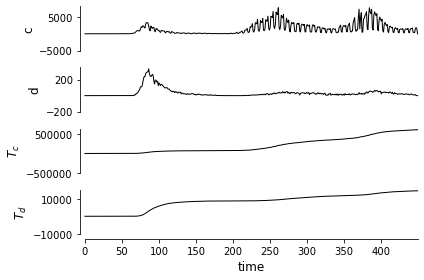

In [47]:
tp.plot_timeseries(dataframe); plt.show()

In [48]:
parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr,
    verbosity=1)


##
## Estimating lagged dependencies 
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 20


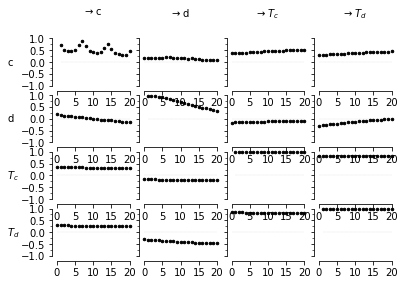

In [49]:
correlations = pcmci.get_lagged_dependencies(tau_max=20, val_only=True)['val_matrix']
lag_func_matrix = tp.plot_lagfuncs(val_matrix=correlations, setup_args={'var_names':var_names, 
                                    'x_base':5, 'y_base':.5}); plt.show()

In [50]:
pcmci.verbosity = 1
results = pcmci.run_pcmci(tau_max=8, pc_alpha=None)


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 8
pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable c has 8 parent(s):
    [pc_alpha = 0.3]
        (c -7): max_pval = 0.00000, min_val =  0.648
        (c -1): max_pval = 0.00000, min_val =  0.288
        (c -6): max_pval = 0.00030, min_val =  0.173
        (d -7): max_pval = 0.04427, min_val =  0.097
        (d -4): max_pval = 0.06130, min_val = -0.091
        (d -3): max_pval = 0.07268, min_val = -0.086
        (c -2): max_pval = 0.23318, min_val = -0.057
        (c -5): max_pval = 0.28952, min_val = -0.051

    Variable d has 4 parent(s):
    [pc_alpha = 0.1]
        (d -1): max_pval = 0.00000, min_val =  0.655
        (d -6): max_pval = 0.00703, min_val = -0.129
        (d -7): max_pval = 0.04531, min_val = -0.096
        (d -2): max_pval = 0.05955, min_val =  0.091

    Va

In [51]:
print("p-values")
print (results['p_matrix'].round(3))
print("MCI partial correlations")
print (results['val_matrix'].round(2))

p-values
[[[1.    0.    0.468 0.    0.029 0.    0.    0.    0.241]
  [0.    0.498 0.32  0.252 0.676 0.737 0.204 0.032 0.336]
  [0.    0.128 0.011 0.001 0.686 0.    0.    0.    0.009]
  [0.    0.027 0.032 0.112 0.921 0.4   0.638 0.13  0.018]]

 [[0.    0.254 0.624 0.    0.217 0.496 0.983 0.051 0.124]
  [1.    0.    0.039 0.008 0.047 0.    0.003 0.    0.244]
  [0.    0.296 0.879 0.    0.167 0.395 0.64  0.072 0.491]
  [0.    0.    0.01  0.    0.    0.    0.    0.    0.002]]

 [[0.    0.927 0.982 0.    0.862 0.997 0.928 0.985 0.339]
  [0.    0.968 0.238 0.483 0.315 0.864 0.129 0.024 0.481]
  [1.    0.798 0.834 0.809 0.716 0.925 0.    0.992 0.884]
  [0.    0.064 0.016 0.06  0.766 0.207 0.969 0.148 0.007]]

 [[0.    0.226 0.797 0.934 0.993 0.404 0.92  0.935 0.067]
  [0.    0.807 0.979 0.002 0.    0.    0.977 0.956 0.143]
  [0.    0.329 0.926 0.814 0.946 0.548 0.594 0.983 0.343]
  [1.    0.    0.    0.    0.    0.001 0.906 0.97  0.86 ]]]
MCI partial correlations
[[[ 0.    0.41 -0.04  0.28  0.

In [52]:
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], fdr_method='fdr_bh')
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)


## Significant links at alpha = 0.01:

    Variable c has 10 link(s):
        ($T_c$  0): pval = 0.00000 | qval = 0.00000 | val =  1.000
        (c -7): pval = 0.00000 | qval = 0.00000 | val =  0.547
        (c -1): pval = 0.00000 | qval = 0.00000 | val =  0.406
        (c -6): pval = 0.00000 | qval = 0.00000 | val =  0.315
        (c -3): pval = 0.00000 | qval = 0.00000 | val =  0.277
        ($T_c$ -3): pval = 0.00000 | qval = 0.00000 | val =  0.269
        (d -3): pval = 0.00000 | qval = 0.00003 | val =  0.221
        ($T_d$  0): pval = 0.00001 | qval = 0.00001 | val =  0.212
        (d  0): pval = 0.00002 | qval = 0.00002 | val =  0.206
        (c -5): pval = 0.00011 | qval = 0.00059 | val =  0.187

    Variable d has 8 link(s):
        ($T_d$  0): pval = 0.00000 | qval = 0.00000 | val =  1.000
        (d -1): pval = 0.00000 | qval = 0.00000 | val =  0.619
        (c  0): pval = 0.00002 | qval = 0.00002 | val =  0.206
        ($T_c$  0): pval = 0.00006 | qval = 0.00006 | val =  0.

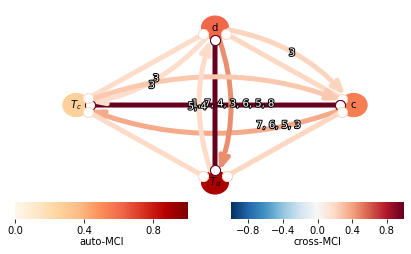

In [54]:
link_matrix = pcmci.return_significant_links(pq_matrix=q_matrix,
                        val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']
tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    ); plt.show()

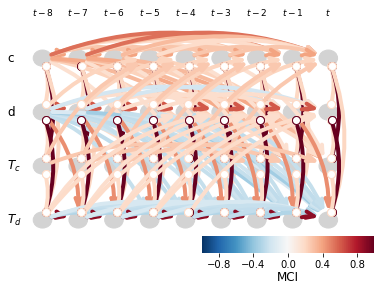

In [55]:
# Plot time series graph    
tp.plot_time_series_graph(
    figsize=(6, 4),
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names,
    link_colorbar_label='MCI',
    ); plt.show()